In [10]:
import tenseal as ts
import torch
from math import pow
import numpy as np

In [11]:
def context(poly, coeffs, glob):    
    context = ts.context(ts.SCHEME_TYPE.CKKS, 
                     poly_modulus_degree=poly, 
                     coeff_mod_bit_sizes=coeffs)
    context.global_scale = glob

    return context

def decrypt(enc):
    return enc.decrypt().tolist()

## First context

In [12]:
ctx = context(8192, [60, 40, 40, 60], pow(2, 40))

In [13]:
x = torch.tensor([[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]])
print(x.shape)
W = torch.tensor([[1], [1], [1], [1], [1]])
W.shape

torch.Size([2, 5])


torch.Size([5, 1])

In [14]:
enc_x = ts.ckks_tensor(ctx, x.tolist(), batch=False)
decrypt(enc_x)

[[1.0000000000092166,
  1.9999999994366078,
  3.000000000553113,
  4.0000000005556275,
  5.000000000030658],
 [1.999999999882291,
  3.0000000000705875,
  3.999999999905333,
  4.999999999535178,
  6.0000000005013066]]

In [15]:
torch.matmul(x, W)

tensor([[15],
        [20]])

In [16]:
enc_y = enc_x.mm(W)
decrypt(enc_y)

[[15.000002011929267], [20.000002681745087]]

In [17]:
decrypt(enc_x * 3)

[[3.0000004020539524,
  6.000000803170516,
  9.0000012085172,
  12.000001610609694,
  15.000002012185607],
 [6.000000803839648,
  9.000001207635316,
  12.000001609474996,
  15.000002010915791,
  18.000002415442353]]

In [18]:
ctx = context(4096, [40, 20, 20], pow(2, 21))
# ctx = context(2048, [18, 18, 18], pow(2, 16))

## MNIST Visual Invertibility

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [4]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [17]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data/mnist', 
        train=True, 
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=batch_size_train, 
    shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST(
        'data/mnist',
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=batch_size_test, 
    shuffle=True
)

In [18]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [19]:
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


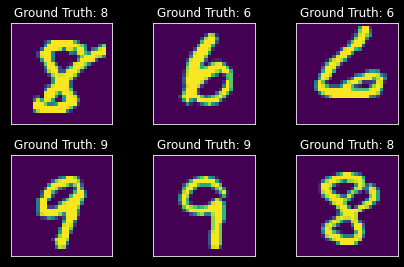

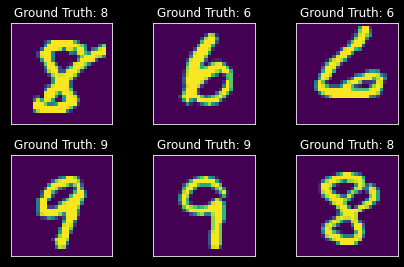

In [21]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [25]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [35]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './weights/mnist_model.pth')
      torch.save(optimizer.state_dict(), './weights/mnist_optimizer.pth')

In [36]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [37]:
test()

/tmp/ipykernel_3627/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0892, Accuracy: 9724/10000 (97%)



In [38]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_3627/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.323142
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.227395
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.378916
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.177530
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.303341
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.355422
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.348386
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.253176
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.342524
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.263973
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.186482
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.268407
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.387970
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.083028
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.162573
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.209439
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.221012
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.243783
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.262084
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.375924
Train Epoch: 1 [12800/60000 (

## Loading and Plotting the feature maps of the trained network

In [96]:
class TrainedNet(nn.Module):
    def __init__(self):
        super(TrainedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)

        return x

In [97]:
trained_net = TrainedNet()
trained_net.load_state_dict(torch.load('./weights/mnist_model.pth'))
trained_net.eval()

TrainedNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [98]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
out = trained_net(example_data)
out = out.detach().numpy()

In [99]:
out.shape

(1000, 320)

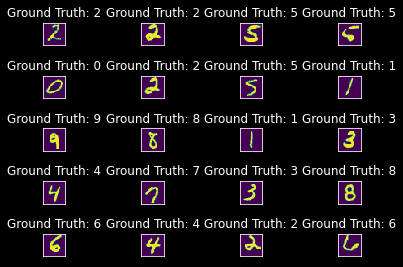

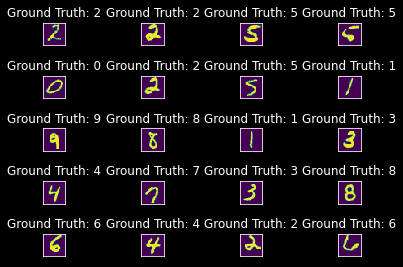

In [100]:
fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Plotting out the feature maps

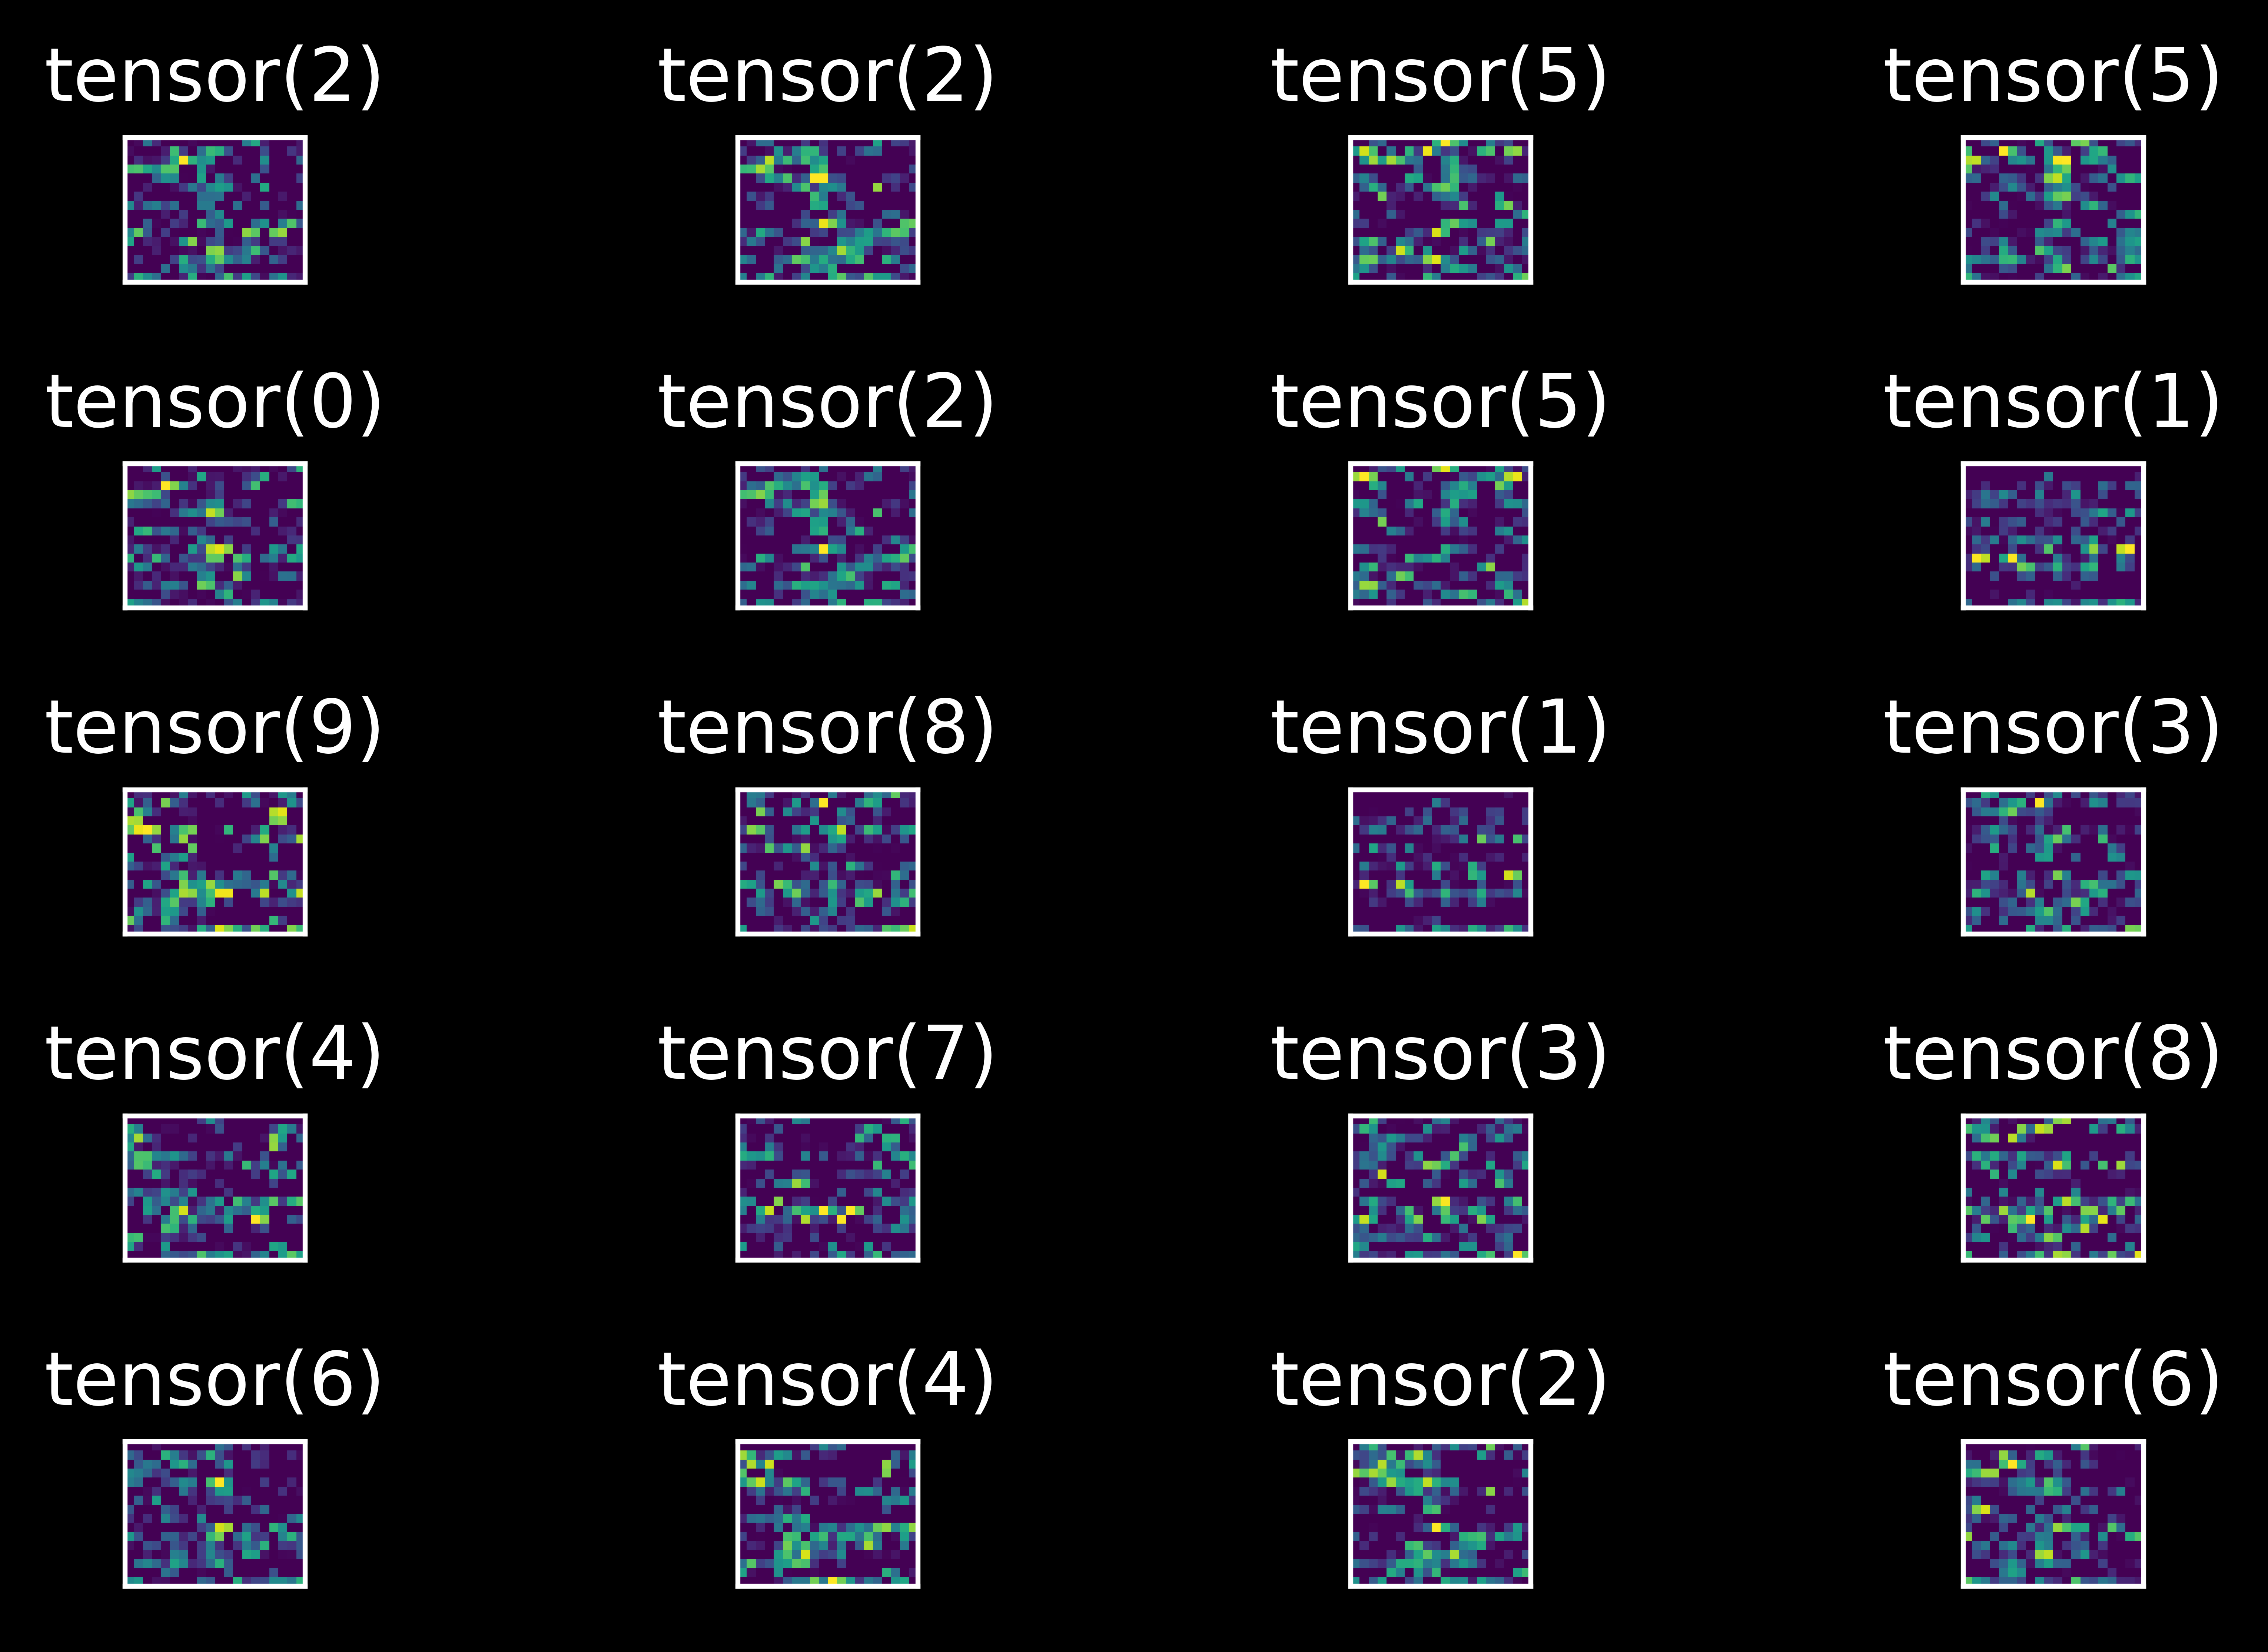

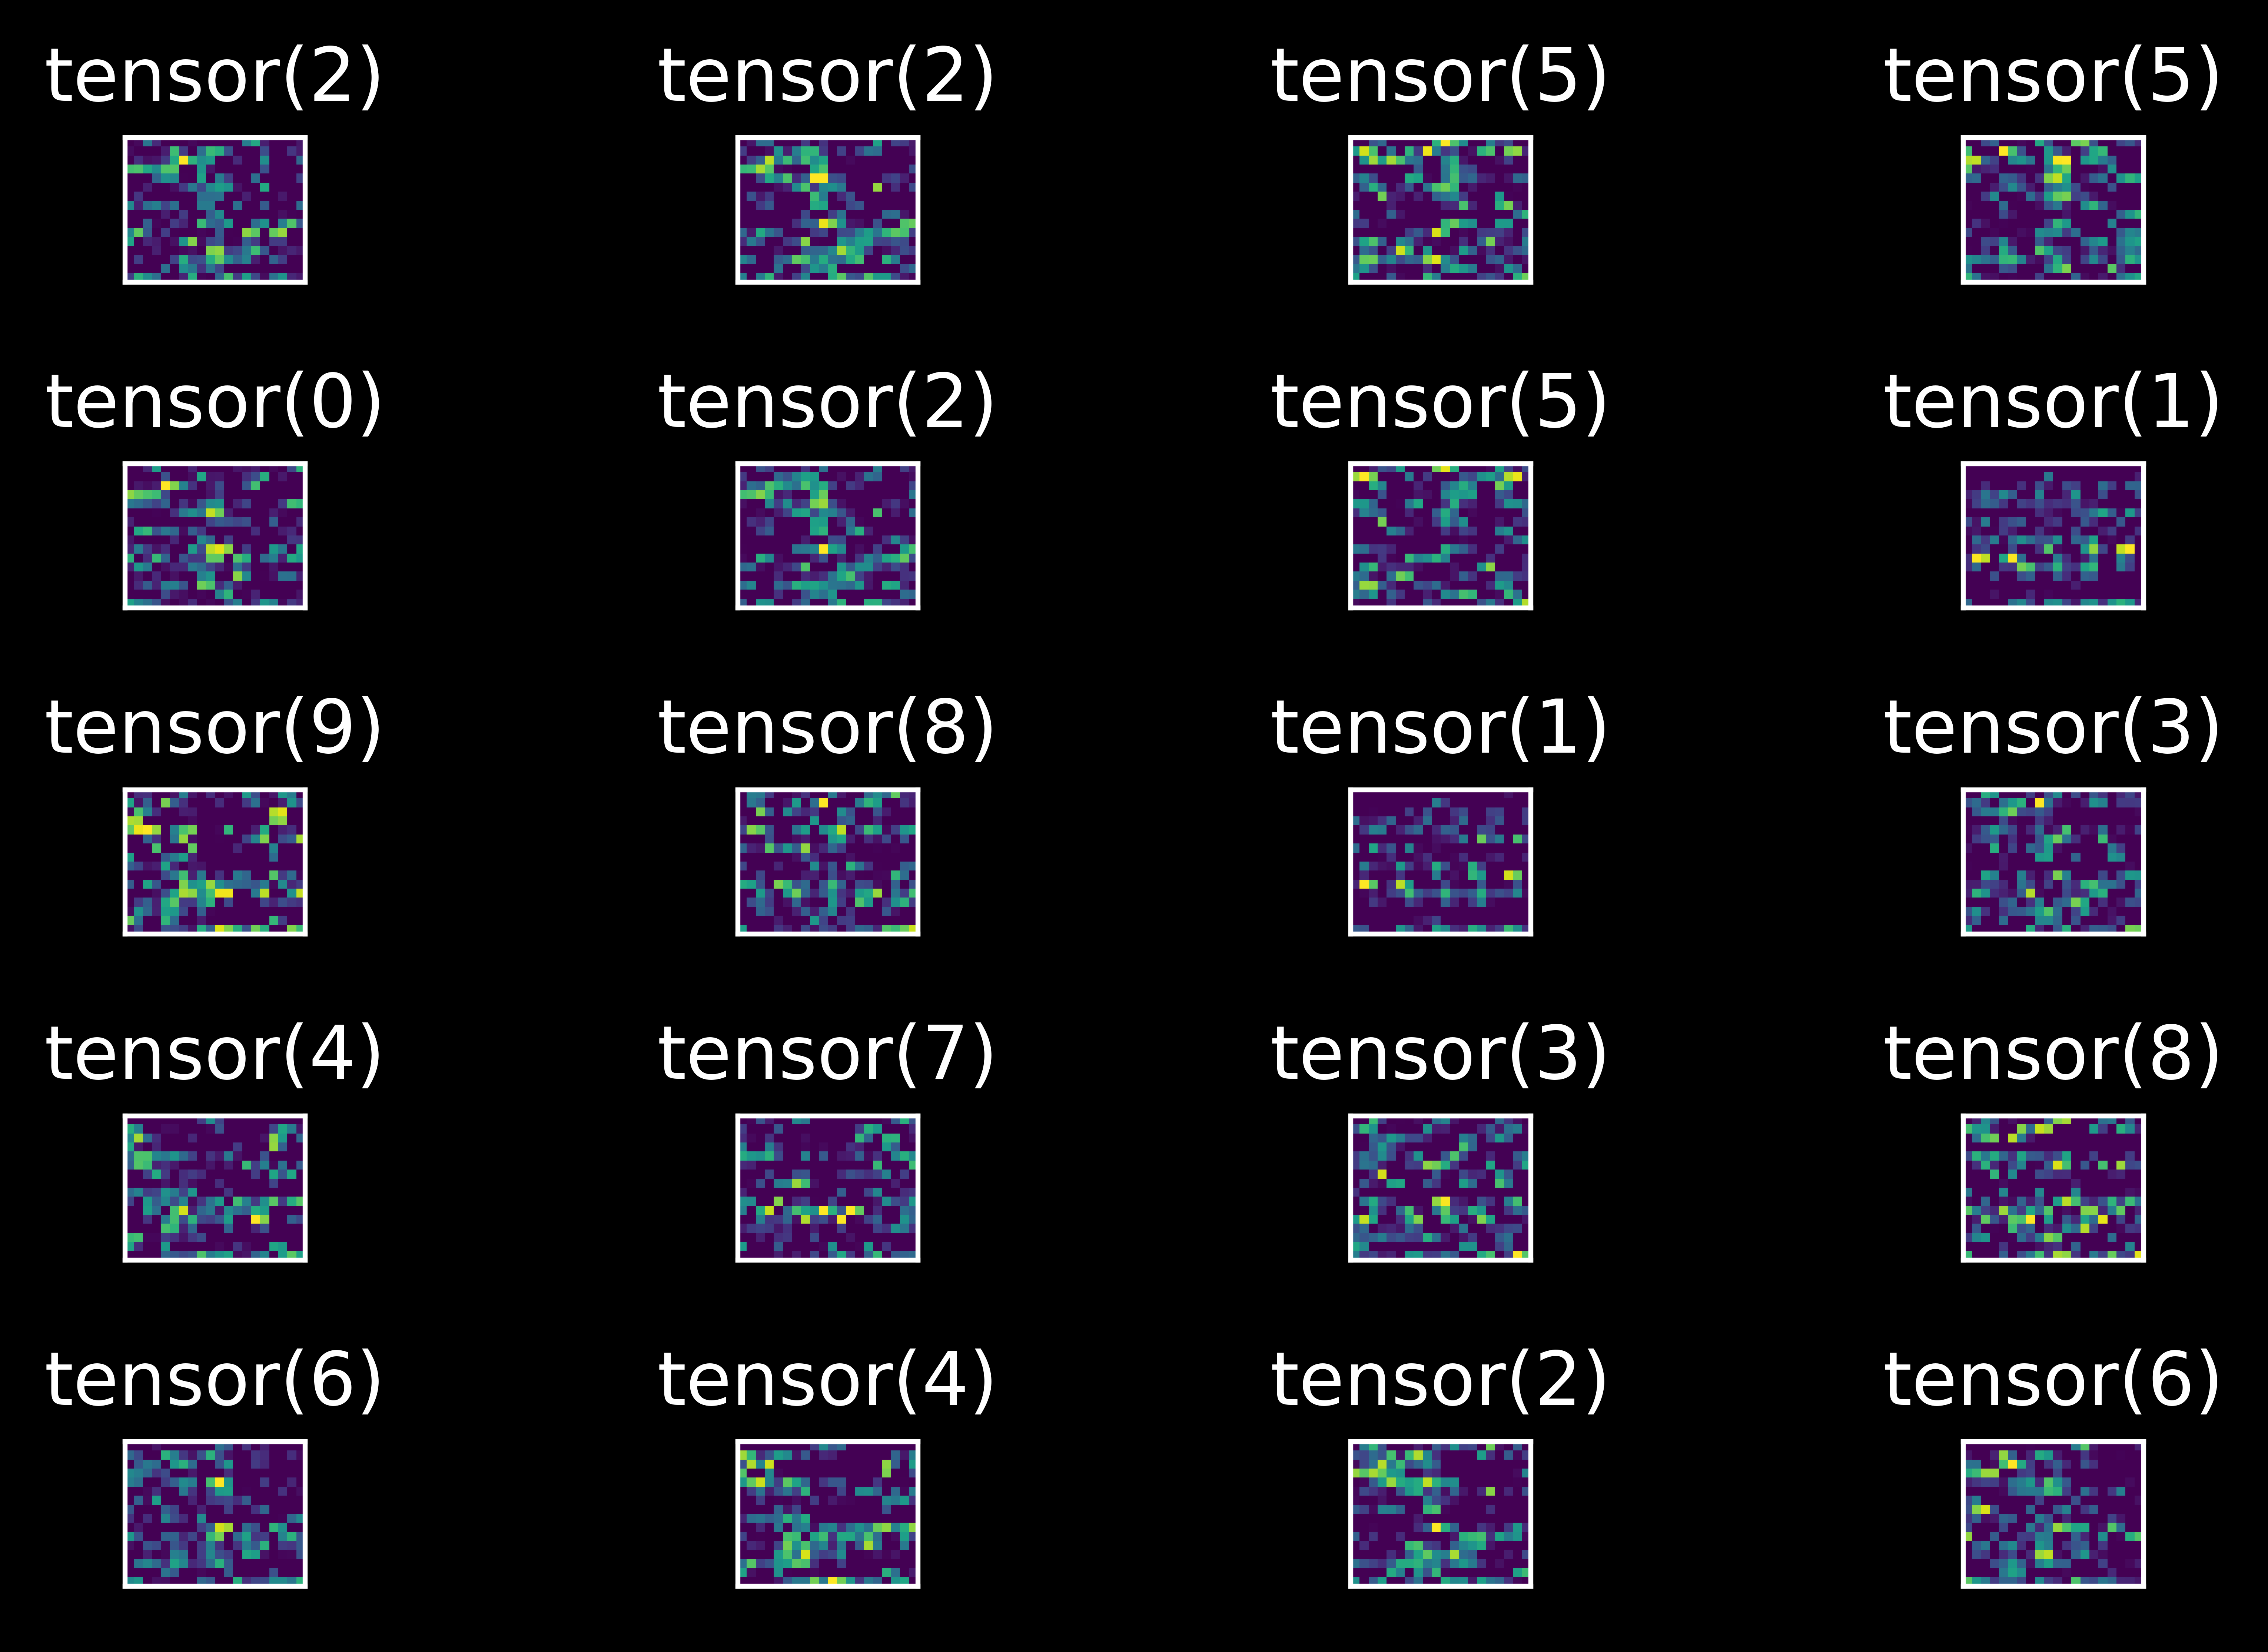

In [121]:
fig = plt.figure(dpi=1200)
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(out[i].reshape((16, 20)))
  plt.title(example_targets[i])
  plt.xticks([])
  plt.yticks([])
fig

tensor(2)


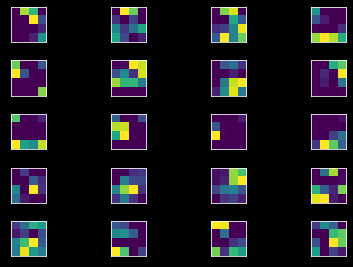

In [95]:
im_indx = 5
print(example_targets[im_indx])
fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(out[im_indx][i], interpolation='none')
  plt.xticks([])
  plt.yticks([])

tensor(4)


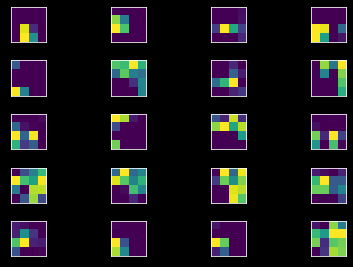

In [90]:
im_indx = 2
print(example_targets[im_indx])
fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(out[im_indx][i], interpolation='none')
  plt.xticks([])
  plt.yticks([])

tensor(4)


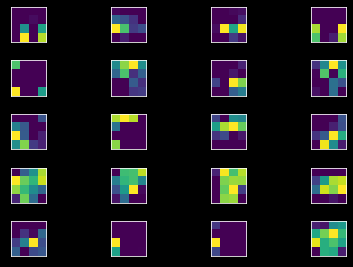

In [91]:
im_indx = 6
print(example_targets[im_indx])
fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(out[im_indx][i], interpolation='none')
  plt.xticks([])
  plt.yticks([])